In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product
from joblib import Parallel, delayed

In [7]:
df = pd.read_csv(f"D:/github/seminar_1/Datasets/revenue_train_data_by_date_store.csv")
df["date"] = pd.to_datetime(df["date"])

In [8]:
# Lọc dữ liệu cho CA_3
df_CA3 = df[df["store_id"] == "CA_3"].copy()
df_CA3 = df_CA3.sort_values(by="date")
print(df_CA3.head())

         date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
2  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
12 2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
22 2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
32 2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
42 2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

   event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI store_id  \
2           NaN          NaN          NaN        0        0        0     CA_3   
12          NaN          NaN          NaN        0        0        0     CA_3   
22          NaN          NaN          NaN        0        0        0     CA_3   
32          NaN          NaN          NaN        1        1        0     CA_3   
42          NaN          NaN          NaN        1        0        1     CA_3   

     revenue  
2   11679.83  
12  12161.46  
22   9123.86  
32

EDA & Data Process

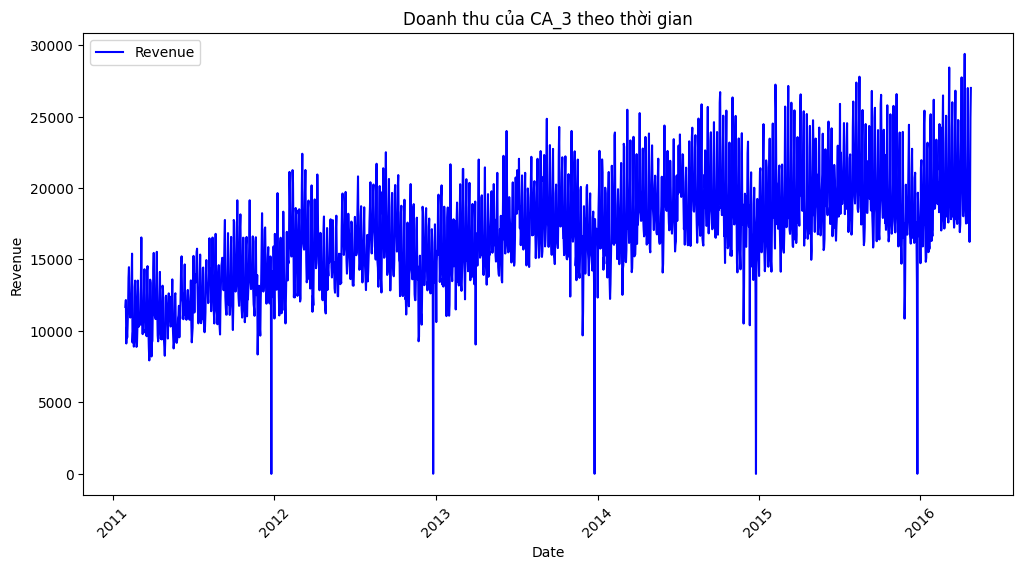

In [9]:
# Vẽ biểu đồ doanh thu theo thời gian
plt.figure(figsize=(12,6))
plt.plot(df_CA3['date'], df_CA3['revenue'], color='blue', label='Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Doanh thu của CA_3 theo thời gian')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [11]:
# Kiểm tra tính dừng với ADF Test
y_CA3 = df_CA3["revenue"]
adf_test = adfuller(y_CA3)
adf_statistic, p_value = adf_test[0], adf_test[1]
print(f"ADF Statistic: {adf_statistic:.4f}, p-value: {p_value:.4f}")

ADF Statistic: -1.7572, p-value: 0.4019


- Kết quả kiểm tra tính dừng (ADF Test)
ADF Statistic = -1.7572
p-value = 0.4019 (> 0.05)
- Kết luận:
Dữ liệu doanh thu của CA_3 không có tính dừng, vì p-value > 0.05.
Cần thực hiện sai phân để làm cho chuỗi trở nên dừng.

In [12]:
if p_value > 0.05:
    y_CA3_diff = y_CA3.diff().dropna()
    adf_test_diff = adfuller(y_CA3_diff)
    adf_statistic_diff, p_value_diff = adf_test_diff[0], adf_test_diff[1]
    print(f"ADF Statistic after differencing: {adf_statistic_diff:.4f}, p-value: {p_value_diff:.4f}")


ADF Statistic after differencing: -21.0063, p-value: 0.0000


Chuỗi doanh thu của CA_3 đã trở nên dừng sau khi thực hiện sai phân bậc 1

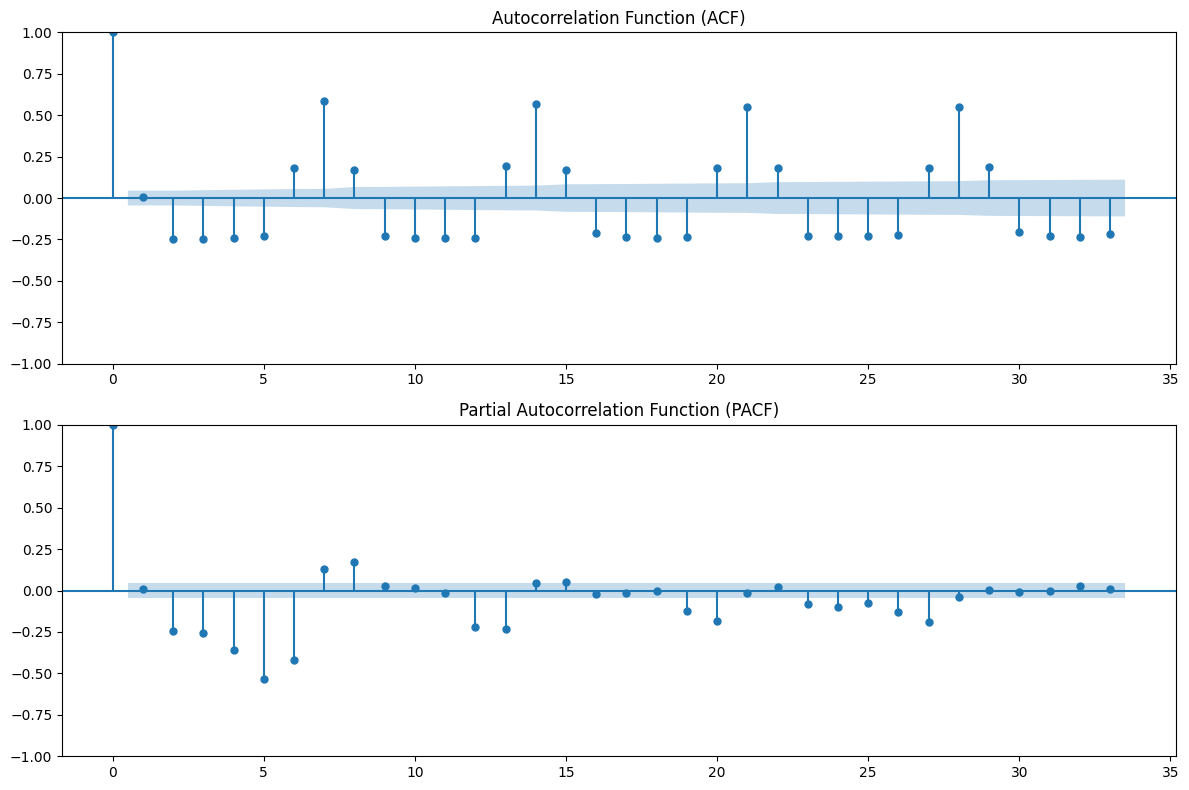

In [13]:
# Vẽ ACF & PACF 
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(y_CA3_diff, ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF)")
plot_pacf(y_CA3_diff, ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.tight_layout()
plt.show()

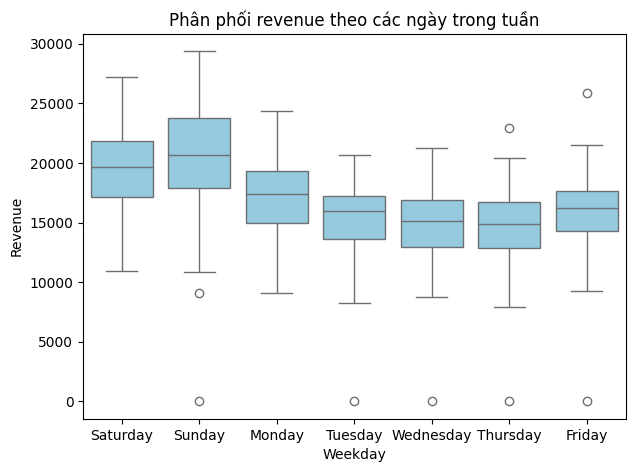

In [14]:
# Vẽ biểu đồ quan sát tương quan giữa revenue và weekday
plt.figure(figsize=(7,5))
sns.boxplot(x=df_CA3["weekday"], y=df_CA3["revenue"], color="skyblue")
plt.xlabel("Weekday")
plt.ylabel("Revenue")
plt.title("Phân phối revenue theo các ngày trong tuần")
plt.show()

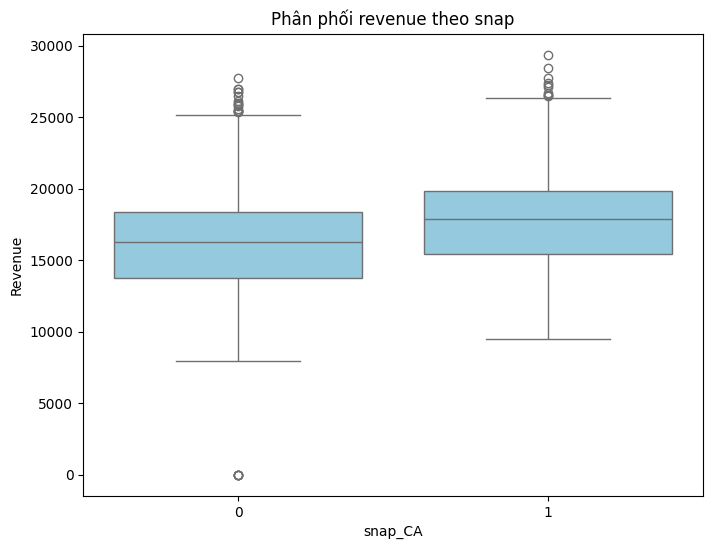

In [15]:
# Vẽ biểu đồ quan sát tương quan giữa revenue và snap
plt.figure(figsize=(8,6))
sns.boxplot(x=df_CA3["snap_CA"], y=df_CA3["revenue"], color="skyblue")
plt.xlabel("snap_CA")
plt.ylabel("Revenue")
plt.title("Phân phối revenue theo snap")
plt.show()

In [16]:
# Gộp cả hai cột event_name_1 và event_name_2 thành một danh sách sự kiện trong mỗi ngày
df_CA3['all_events'] = df_CA3[['event_name_1', 'event_name_2']].apply(lambda x: list(set(x.dropna())), axis=1)

# Tạo biến giả từ danh sách sự kiện
event_dummies = df_CA3['all_events'].explode().str.get_dummies().groupby(level=0).max()
event_dummies = event_dummies.add_prefix("all_event_")

# Gộp các biến giả vào dataframe chính
df_CA3 = pd.concat([df_CA3, event_dummies], axis=1)

df_CA3 = pd.get_dummies(df_CA3, columns=["weekday"], drop_first=True)



In [22]:
df_CA3.head()

,date,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,...,all_event_SuperBowl,all_event_Thanksgiving,all_event_ValentinesDay,all_event_VeteransDay,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
2,2011-01-29,11101,1,1,2011,d_1,NaN,NaN,NaN,NaN,...,0,0,0,0,False,True,False,False,False,False
12,2011-01-30,11101,2,1,2011,d_2,NaN,NaN,NaN,NaN,...,0,0,0,0,False,False,True,False,False,False
22,2011-01-31,11101,3,1,2011,d_3,NaN,NaN,NaN,NaN,...,0,0,0,0,True,False,False,False,False,False
32,2011-02-01,11101,4,2,2011,d_4,NaN,NaN,NaN,NaN,...,0,0,0,0,False,False,False,False,True,False
42,2011-02-02,11101,5,2,2011,d_5,NaN,NaN,NaN,NaN,...,0,0,0,0,False,False,False,False,False,True


ARIMAX

In [26]:
# Biến mục tiêu (y) và biến ngoại sinh (X)
y_CA3 = df_CA3["revenue"].reset_index(drop=True)
X_CA3 = df_CA3[["snap_CA"] + [col for col in df_CA3.columns if col.startswith("weekday_")]+ [col for col in df_CA3.columns if col.startswith("all_event_")]].reset_index(drop=True)
X_CA3 = X_CA3.astype(int)

# Chia dữ liệu:  test 30 ngày cuối
y_train, y_test = y_CA3.iloc[:-30], y_CA3.iloc[-30:]
X_train, X_test = X_CA3.iloc[:-30], X_CA3.iloc[-30:]


In [27]:
X_train

,snap_CA,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,all_event_Chanukah End,all_event_Christmas,all_event_Cinco De Mayo,...,all_event_OrthodoxEaster,all_event_Pesach End,all_event_PresidentsDay,all_event_Purim End,all_event_Ramadan starts,all_event_StPatricksDay,all_event_SuperBowl,all_event_Thanksgiving,all_event_ValentinesDay,all_event_VeteransDay
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1879,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1880,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1881,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [28]:
def arima_grid_search(y, X, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    best_model = None
    
    for p, d, q in product(p_values, d_values, q_values):
        try:
            model = SARIMAX(y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)
            y_pred = results.predict(start=len(y_train), end=len(y_CA3)-1, exog=X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            if rmse < best_score:
                best_score, best_cfg = rmse, (p, d, q)
                best_model = results
        except:
            continue
    
    print(f'Best ARIMAX{best_cfg} RMSE={best_score:.2f}')
    return best_cfg, best_model

# Thiết lập giá trị tham số cần tìm
p_values = range(0, 5)
d_values = range(1, 2)
q_values = range(0, 5)

# Chạy grid search
best_params, best_model = arima_grid_search(y_train, X_train, p_values, d_values, q_values)

# Huấn luyện mô hình mới với tham số tối ưu
model_optimized = SARIMAX(y_train, exog=X_train, order=best_params, seasonal_order=(0, 0, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
results_optimized = model_optimized.fit()
print(results_optimized.summary())

# Dự báo trên tập test
y_pred_optimized = results_optimized.predict(start=len(y_train), end=len(y_CA3)-1, exog=X_test)
rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
print(f'Optimized RMSE: {rmse_optimized:.2f}')


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Best ARIMAX(2, 1, 4) RMSE=1391.64
                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                 1883
Model:               SARIMAX(2, 1, 4)   Log Likelihood              -15920.455
Date:                Sat, 01 Mar 2025   AIC                          31928.910
Time:                        00:03:35   BIC                          32172.556
Sample:                             0   HQIC                         32018.659
                               - 1883                                         
Covariance Type:                  opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
snap_CA                        1391.4224     73.101     19.034      0.000    1248.146    1534.699
weekday_Monday                  823.0183

SARIMAX(2, 1, 4) Optimized RMSE: 1391.64

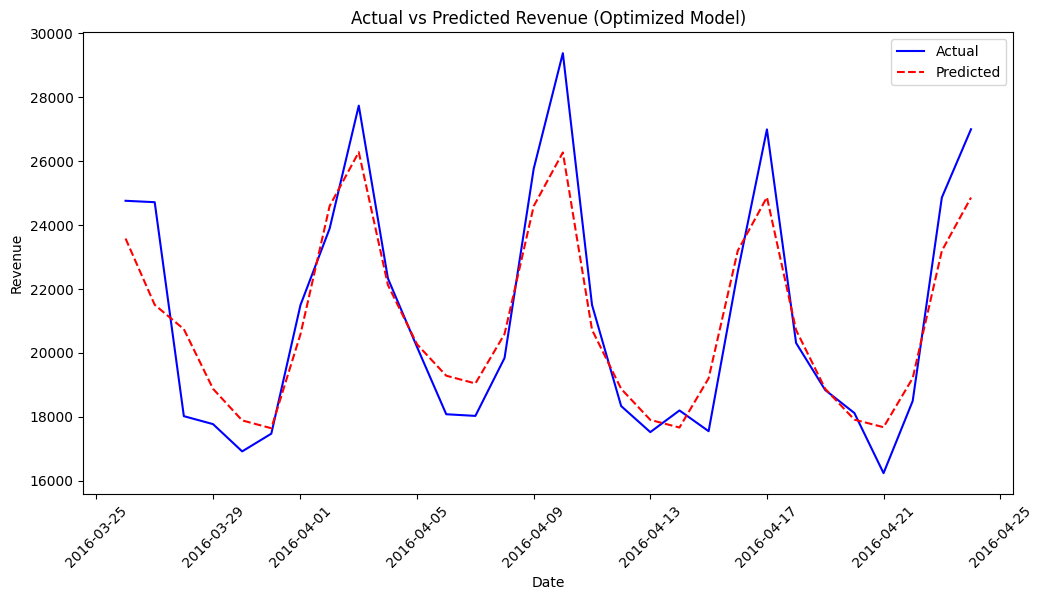

In [29]:
plt.figure(figsize=(12,6))
plt.plot(df_CA3['date'].iloc[-30:], y_test, label='Actual', color='blue')
plt.plot(df_CA3['date'].iloc[-30:], y_pred_optimized, label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue (Optimized Model)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Forecast for 28 days

In [52]:
df_test = pd.read_csv(f"D:/github/seminar_1/Datasets/revenue_test_data_by_date_store.csv")
df_test["date"] = pd.to_datetime(df_test["date"])
df_test = df_test.drop(columns=["revenue"], errors='ignore')
df_CA3_test = df[df["store_id"] == "CA_3"].copy()
df_CA3_test = df_CA3_test.sort_values(by="date")
df_CA3_test = df_CA3_test.iloc[-28:,]

In [53]:
# Gộp cả hai cột event_name_1 và event_name_2 thành một danh sách sự kiện trong mỗi ngày
df_CA3_test['all_events'] = df_CA3_test[['event_name_1', 'event_name_2']].apply(lambda x: list(set(x.dropna())), axis=1)

# Tạo biến giả từ danh sách sự kiện
event_dummies = df_CA3_test['all_events'].explode().str.get_dummies().groupby(level=0).max()
event_dummies = event_dummies.add_prefix("all_event_")

# Gộp các biến giả vào dataframe chính
df_CA3_test = pd.concat([df_CA3_test, event_dummies], axis=1)

df_CA3_test = pd.get_dummies(df_CA3_test, columns=["weekday"], drop_first=True)
X_CA3_test = df_CA3_test[["snap_CA"] + [col for col in df_CA3_test.columns if col.startswith("weekday_")]+ [col for col in df_CA3_test.columns if col.startswith("all_event_")]].reset_index(drop=True)
X_CA3_test = X_CA3_test.reindex(columns=X_CA3.columns, fill_value=0).reset_index(drop=True)
X_CA3_test = X_CA3_test.astype(int)



In [54]:
#Train model cho df_CA3
model_optimized = SARIMAX(y_CA3, exog=X_CA3, order=(2,1,4), seasonal_order=(0, 0, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
results_optimized = model_optimized.fit()

In [55]:
X_future = X_CA3_test.iloc[-28:].reset_index(drop=True)
y_future_pred = results_optimized.predict(start=len(y_CA3), end=len(y_CA3) + 27, exog=X_future)
future_dates = pd.date_range(start=df_CA3['date'].iloc[-1] + pd.Timedelta(days=1), periods=28)
future_df = pd.DataFrame({
    "id": range(1914, 1914 + 28),
    "date": future_dates,
    "d": [f"d_{i}" for i in range(1914, 1914 + 28)],
    "CA_3": y_future_pred.values
})
print(future_df)

      id       date       d          CA_3
0   1914 2016-04-25  d_1914  21626.895435
1   1915 2016-04-26  d_1915  19168.190687
2   1916 2016-04-27  d_1916  17854.431396
3   1917 2016-04-28  d_1917  17510.391614
4   1918 2016-04-29  d_1918  20686.246881
5   1919 2016-04-30  d_1919  25055.739437
6   1920 2016-05-01  d_1920  26996.009031
7   1921 2016-05-02  d_1921  22744.878358
8   1922 2016-05-03  d_1922  20599.739719
9   1923 2016-05-04  d_1923  19306.343544
10  1924 2016-05-05  d_1924  18966.804416
11  1925 2016-05-06  d_1925  20697.063944
12  1926 2016-05-07  d_1926  25043.911244
13  1927 2016-05-08  d_1927  26970.571286
14  1928 2016-05-09  d_1928  21294.051225
15  1929 2016-05-10  d_1929  19169.356931
16  1930 2016-05-11  d_1930  17895.823888
17  1931 2016-05-12  d_1931  17560.662751
18  1932 2016-05-13  d_1932  19276.637487
19  1933 2016-05-14  d_1933  23601.388855
20  1934 2016-05-15  d_1934  25514.780186
21  1935 2016-05-16  d_1935  21274.682460
22  1936 2016-05-17  d_1936  19169

In [56]:
future_df.to_csv(f"D:/github/seminar_1/Evaluation/Result/Phuong/ARIMAX_CA3.csv", index=False)

SARIMAX

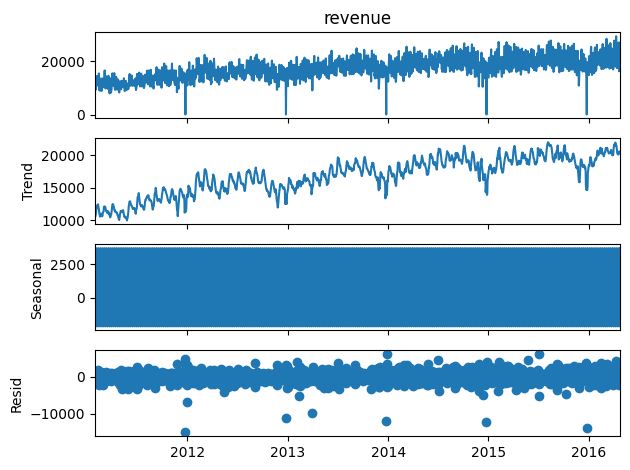

In [57]:
result = seasonal_decompose(df_CA3.set_index("date")["revenue"], model='additive', period=7)
result.plot()
plt.show()

In [58]:
# Biến mục tiêu (y) và biến ngoại sinh (X)
y_CA3 = df_CA3["revenue"].reset_index(drop=True)
X_CA3 = df_CA3[["snap_CA"] + [col for col in df_CA3.columns if col.startswith("all_event_")]].reset_index(drop=True)

# Chia dữ liệu: train 1500 ngày đầu, test 30 ngày cuối
y_train, y_test = y_CA3.iloc[:-30], y_CA3.iloc[-30:]
X_train, X_test = X_CA3.iloc[:-30], X_CA3.iloc[-30:]

In [59]:
# Tìm bộ tham số tốt nhất cho SARIMAX
p_values = [1,2]
d_values = [1]
q_values = [1,2]
P_values = [1,2]
D_values = [0,1]
Q_values = [1,2]
s = 7 

best_score = float("inf")
best_rmsse = float("inf")
best_cfg = None
best_model = None

for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
    try:
        model = SARIMAX(y_train, exog=X_train, order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)
        y_pred = results.predict(start=len(y_train), end=len(y_CA3)-1, exog=X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        scale = np.mean(np.abs(np.diff(y_train)))
        rmsse = np.sqrt(np.mean(((y_test - y_pred) / scale) ** 2))
        # print(f'SARIMAX{(p, d, q, P, D, Q)} RMSE={rmse:.2f}, RMSSE={rmsse:.4f}')
        
        if rmse < best_score:
            best_score, best_rmsse, best_cfg, best_model = rmse, rmsse, (p, d, q, P, D, Q), results
    except:
        continue

print(f'Best SARIMAX{best_cfg} RMSE={best_score:.2f}, RMSSE={best_rmsse:.4f}')

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Best SARIMAX(2, 1, 2, 2, 0, 2) RMSE=1103.88, RMSSE=0.5310


In [60]:
p_opt, d_opt, q_opt, P_opt, D_opt, Q_opt = best_cfg
model_sarimax = SARIMAX(y_train, exog=X_train, order=(p_opt, d_opt, q_opt), seasonal_order=(P_opt, D_opt, Q_opt, s), enforce_stationarity=False, enforce_invertibility=False)
results_sarimax = model_sarimax.fit()
y_pred = results_sarimax.predict(start=len(y_train), end=len(y_CA3)-1, exog=X_test)
print(results_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           revenue   No. Observations:                 1883
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -15934.972
Date:                           Sat, 01 Mar 2025   AIC                          31949.944
Time:                                   00:33:55   BIC                          32171.184
Sample:                                        0   HQIC                         32031.466
                                          - 1883                                         
Covariance Type:                             opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
snap_CA                        1400.8226    111.942     12.514      0.000    1181.42

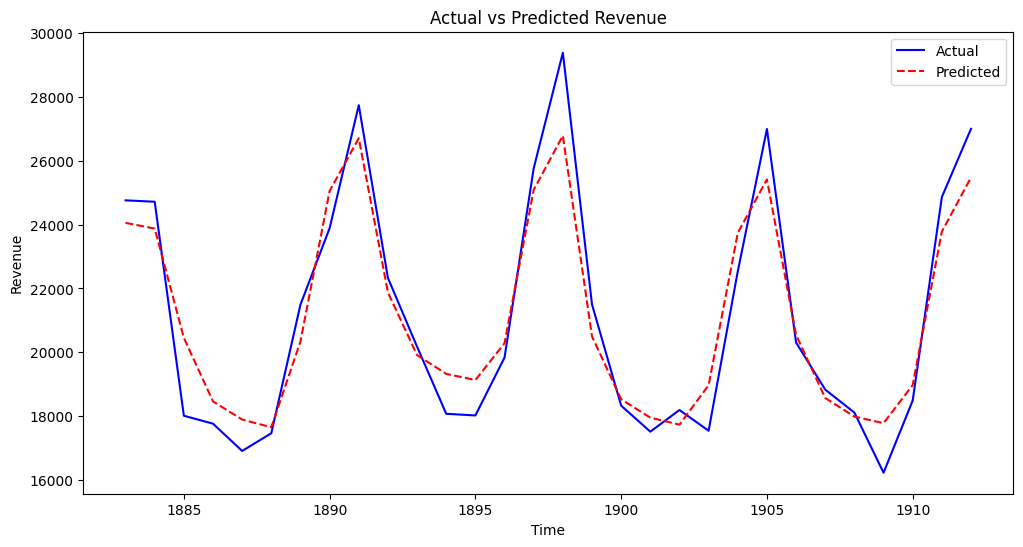

In [61]:
# Vẽ biểu đồ so sánh kết quả dự báo với thực tế
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')
plt.legend()
plt.show()

Forecast 28 days

In [62]:
X_CA3_test_sarimax = df_CA3_test[["snap_CA"] +  [col for col in df_CA3_test.columns if col.startswith("all_event_")]].reset_index(drop=True)
X_CA3_test_sarimax = X_CA3_test_sarimax.reindex(columns=X_CA3.columns, fill_value=0).reset_index(drop=True)
X_CA3_test_sarimax = X_CA3_test_sarimax.astype(int)



In [63]:
#Huấn luyện với y_CA3
model_sarimax = SARIMAX(y_CA3, exog=X_CA3, order=(2, 1, 2), seasonal_order=(2, 0, 2, 7), enforce_stationarity=False, enforce_invertibility=False)
results_model_sarimax = model_sarimax.fit()

In [65]:
X_future_sarimax = X_CA3_test_sarimax.iloc[-28:].reset_index(drop=True)
y_future_pred = results_model_sarimax.predict(start=len(y_CA3), end=len(y_CA3) + 27, exog=X_future_sarimax)
future_dates = pd.date_range(start=df_CA3['date'].iloc[-1] + pd.Timedelta(days=1), periods=28)
future_sarimax_df = pd.DataFrame({
    "id": range(1914, 1914 + 28),
    "date": future_dates,
    "d": [f"d_{i}" for i in range(1914, 1914 + 28)],
    "CA_3": y_future_pred.values
})
print(future_sarimax_df)

      id       date       d          CA_3
0   1914 2016-04-25  d_1914  21033.807134
1   1915 2016-04-26  d_1915  18800.081343
2   1916 2016-04-27  d_1916  18098.178167
3   1917 2016-04-28  d_1917  17802.750251
4   1918 2016-04-29  d_1918  20593.950659
5   1919 2016-04-30  d_1919  25518.482356
6   1920 2016-05-01  d_1920  27287.434877
7   1921 2016-05-02  d_1921  22222.321084
8   1922 2016-05-03  d_1922  20209.440064
9   1923 2016-05-04  d_1923  19588.575332
10  1924 2016-05-05  d_1924  19412.943713
11  1925 2016-05-06  d_1925  20623.891097
12  1926 2016-05-07  d_1926  25473.261455
13  1927 2016-05-08  d_1927  27297.158822
14  1928 2016-05-09  d_1928  20753.638983
15  1929 2016-05-10  d_1929  18765.295158
16  1930 2016-05-11  d_1930  18137.794031
17  1931 2016-05-12  d_1931  17907.274135
18  1932 2016-05-13  d_1932  19177.214546
19  1933 2016-05-14  d_1933  24086.954994
20  1934 2016-05-15  d_1934  25888.247775
21  1935 2016-05-16  d_1935  20806.990997
22  1936 2016-05-17  d_1936  18797

In [66]:
future_sarimax_df.to_csv(f"D:/github/seminar_1/Evaluation/Result/Phuong/SARIMAX_CA3.csv", index=False)